# Pseudotime Trajectory Inference

Note: This picks up after the Joint Representation notebook

### Import Packages and Load Data

In [ ]:
import mira
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import warnings
warnings.simplefilter("ignore")
import random
import os

umap_kwargs = dict(
    legend_fontweight=350, frameon = False, legend_fontsize=10
)

In [ ]:
#To start from beginning:
#Load data and topic models

os.chdir('/wynton/home/bruneau/jmuncie/MIRA_analysis/Mef2c') 
data_RNA = anndata.read_h5ad("Mef2c_RNA_AnnData.h5ad")
data_Peaks = anndata.read_h5ad("Mef2c_Peaks_AnnData.h5ad")

mef2c_exp_model = mira.topics.ExpressionTopicModel.load('models/Mef2c_RNA_ExpressionTopicModel.pth')
mef2c_atac_model = mira.topics.AccessibilityTopicModel.load('models/Mef2c_ATAC_TopicModel.pth')

In [ ]:
#To resume with CM-IFT lineage, UMAPs made, topics predicted, etc.
os.chdir('/wynton/home/bruneau/jmuncie/MIRA_analysis/Mef2c')
data_sub_RNA = anndata.read_h5ad("Lineage_AnnData/Mef2c_CM-IFT_RNA_AnnData.h5ad")
data_sub_Peaks = anndata.read_h5ad("Lineage_AnnData/Mef2c_CM-IFT_Peaks_AnnData.h5ad")

mef2c_exp_model = mira.topics.ExpressionTopicModel.load('models/Mef2c_RNA_ExpressionTopicModel.pth')
mef2c_atac_model = mira.topics.AccessibilityTopicModel.load('models/Mef2c_ATAC_TopicModel.pth')

### Quick Test - FHF and pSHF as multiple starting points
### ---------------------------------------------------------------------------------------------------------------------------------


In [ ]:
#Subset objects

data_sub_test_RNA = data_RNA[
    data_RNA.obs.Timepoint_x_Cell_Type.isin(
    ['E7.75_CMs/FHF', 'E7.75_JCF',
     'E8.5_CMs-IFT', 'E8.5_pSHF', 
     'E9_CMs-A', 'E9_CMs-AVC'])
]

data_sub_test_Peaks = data_Peaks[
    data_RNA.obs.Timepoint_x_Cell_Type.isin(
    ['E7.75_CMs/FHF', 'E7.75_JCF',
     'E8.5_CMs-IFT', 'E8.5_pSHF', 
     'E9_CMs-A', 'E9_CMs-AVC'])
]

data_sub_test_RNA.obs.Timepoint_x_Cell_Type.unique()

In [ ]:
#Predict topics - note: topics models need to be loaded (near beginning of notebook)

mef2c_exp_model.predict(data_sub_test_RNA)
mef2c_atac_model.predict(data_sub_test_Peaks)

In [ ]:
#Turn off logging to avoid being swamped with messages
mira.adata_interface.core.logger.setLevel(logging.WARN)
mira.adata_interface.topic_model.logger.setLevel(logging.WARN)
mira.adata_interface.utils.logger.setLevel(logging.WARN)

In [ ]:
#Make finalized UMAP

mef2c_exp_model.get_umap_features(data_sub_test_RNA, box_cox=0.5)
mef2c_atac_model.get_umap_features(data_sub_test_Peaks, box_cox=0.5)

data_sub_test_RNA, data_sub_test_Peaks = mira.utils.make_joint_representation(
    data_sub_test_RNA, data_sub_test_Peaks)

sc.pp.neighbors(data_sub_test_RNA, use_rep = 'X_joint_umap_features', metric = 'manhattan', n_neighbors = 15)
sc.tl.umap(data_sub_test_RNA, spread = 0.5, min_dist = 0.7, negative_sample_rate = 2)

In [ ]:
#Display UMAP

def display_fun(ax, display, rna):
    sc.pl.umap(rna, ax = ax, show = False, title = display_titles[display], size = 75,
              color = display_strings[display], palette = colormaps[display], legend_loc='right margin',
              add_outline=False, legend_fontweight=150, frameon = False, legend_fontsize=12)

fig, ax = plt.subplots(2,1, figsize=(4,8))
display_strings = ['Timepoint_x_Cell_Type', 'Genotype']
display_titles = ['Cell Type', 'Genotype']
celltype_colors = ['#bc6c25', '#d4a373', '#bfd7ea','#0b3954','#ff6663', '#99100e']
genotype_colors = ['#66347F', '#E5BEEC']
colormaps = [celltype_colors, genotype_colors]
for ax_i, display in zip(ax, [0, 1]):
    display_fun(ax_i, display, data_sub_test_RNA)

plt.savefig('plots/Mef2c_IFT_2-start_FHF_pSHF_UMAPs_celltype_genotype.pdf')
plt.show()

#### Note: connectivity is much better for E8.5 pSHF than for E7.75 - will proceed using E8.5 pSHF as starting point

### Defining Pseudotime - CMs-IFT lineage
### -----------------------------------------------------------------------------------------------------------------------------


In [ ]:
#Subset objects

data_sub_RNA = data_RNA[
    data_RNA.obs.Timepoint_x_Cell_Type.isin(
    ['E8.5_CMs-IFT', 'E8.5_pSHF', 
     'E9_CMs-A', 'E9_CMs-AVC'])
]

data_sub_Peaks = data_Peaks[
    data_RNA.obs.Timepoint_x_Cell_Type.isin(
    ['E8.5_CMs-IFT', 'E8.5_pSHF', 
     'E9_CMs-A', 'E9_CMs-AVC'])
]

data_sub_RNA.obs.Timepoint_x_Cell_Type.unique()

In [ ]:
#Predict topics - note: topics models need to be loaded (near beginning of notebook)

mef2c_exp_model.predict(data_sub_RNA)
mef2c_atac_model.predict(data_sub_Peaks)

**Create UMAPs**  
Iterate over parameters

In [ ]:
#Turn off logging to avoid being swamped with messages
mira.adata_interface.core.logger.setLevel(logging.WARN)
mira.adata_interface.topic_model.logger.setLevel(logging.WARN)
mira.adata_interface.utils.logger.setLevel(logging.WARN)

In [ ]:
#Iterate over box_cox parameter, colored by cell type

def box_cox_test(ax, boxcox, rna, atac):
    
    mef2c_exp_model.get_umap_features(rna, box_cox=boxcox)
    mef2c_atac_model.get_umap_features(atac, box_cox=boxcox)

    rna, atac = mira.utils.make_joint_representation(rna, atac)

    sc.pp.neighbors(rna, use_rep = 'X_joint_umap_features', metric = 'manhattan', n_neighbors = 15)
    sc.tl.umap(rna, min_dist = 0.1)
    sc.pl.umap(rna, ax = ax, show = False, title = 'Box_Cox: ' + str(boxcox),
              color = 'Timepoint_x_Cell_Type', color_map = 'Set3', legend_loc='on data',
              add_outline=True, outline_width=(0.1,0), outline_color=('grey', 'white'),
              legend_fontweight=150, frameon = False, legend_fontsize=12)

fig, ax = plt.subplots(1,4, figsize=(20,4))
for ax_i, boxcox in zip(ax, [0.1, 0.5, 0.75, 0.99]):
    box_cox_test(ax_i, boxcox, data_sub_RNA, data_sub_Peaks)

plt.show()

In [ ]:
#Go with Box_Cox = 0.75
#Iterate over n_neighbors parameter, colored by cell type

def neighbors_test(ax, neighbors, rna, atac):

    mef2c_exp_model.get_umap_features(rna, box_cox=0.75)
    mef2c_atac_model.get_umap_features(atac, box_cox=0.75)
    
    rna, atac = mira.utils.make_joint_representation(rna, atac)

    sc.pp.neighbors(rna, use_rep = 'X_joint_umap_features', metric = 'manhattan', n_neighbors = neighbors)
    sc.tl.umap(rna, min_dist = 0.1)
    sc.pl.umap(rna, ax = ax, show = False, title = 'n_neighbors: ' + str(neighbors),
              color = 'Timepoint_x_Cell_Type', color_map = 'Set3', legend_loc='on data',
              add_outline=True, outline_width=(0.1,0), outline_color=('grey', 'white'),
              legend_fontweight=150, frameon = False, legend_fontsize=12)

fig, ax = plt.subplots(1,4, figsize=(20,4))
for ax_i, neighbors in zip(ax, [5,10,15,30]):
    neighbors_test(ax_i, neighbors, data_sub_RNA, data_sub_Peaks)

plt.show()

In [ ]:
#Go with n_neighbors = 5
#Iterate over min_dist 
#Note: At this point, I also changed spread parameter from default of 1 to 0.5

def min_dist_test(ax, dist, rna, atac):

    mef2c_exp_model.get_umap_features(rna, box_cox=0.75)
    mef2c_atac_model.get_umap_features(atac, box_cox=0.75)
    
    rna, atac = mira.utils.make_joint_representation(rna, atac)

    sc.pp.neighbors(rna, use_rep = 'X_joint_umap_features', metric = 'manhattan', n_neighbors = 5)
    sc.tl.umap(rna, spread = 0.5, min_dist = dist, negative_sample_rate = 5)
    sc.pl.umap(rna, ax = ax, show = False, title = 'min_dist: ' + str(dist),
              color = 'Timepoint_x_Cell_Type', color_map = 'Set3', legend_loc='on data',
              add_outline=True, outline_width=(0.1,0), outline_color=('grey', 'white'),
              legend_fontweight=150, frameon = False, legend_fontsize=12)

fig, ax = plt.subplots(1,4, figsize=(20,4))
for ax_i, dist in zip(ax, [0.2, 0.4, 0.6, 0.8]):
    min_dist_test(ax_i, dist, data_sub_RNA, data_sub_Peaks)

plt.show()

In [ ]:
#Go with spread = 0.5 and min_dist = 0.6
#Iterate over negative_sample_rate

def neg_test(ax, neg_rate, rna, atac):
    
    mef2c_exp_model.get_umap_features(rna, box_cox=0.75)
    mef2c_atac_model.get_umap_features(atac, box_cox=0.75)

    rna, atac = mira.utils.make_joint_representation(rna, atac)

    sc.pp.neighbors(rna, use_rep = 'X_joint_umap_features', metric = 'manhattan', n_neighbors = 5)
    sc.tl.umap(rna, spread = 0.5, min_dist = 0.6, negative_sample_rate = neg_rate)
    sc.pl.umap(rna, ax = ax, show = False, title = 'negative_sample_rate: ' + str(neg_rate),
              color = 'Timepoint_x_Cell_Type', color_map = 'Set3', legend_loc='on data',
              add_outline=True, outline_width=(0.1,0), outline_color=('grey', 'white'),
              legend_fontweight=150, frameon = False, legend_fontsize=12)

fig, ax = plt.subplots(1,4, figsize=(20,4))
for ax_i, neg_rate in zip(ax, [1, 2, 3, 4]):
    neg_test(ax_i, neg_rate, data_sub_RNA, data_sub_Peaks)

plt.show()

In [ ]:
#Make finalized UMAP

mef2c_exp_model.get_umap_features(data_sub_RNA, box_cox=0.75)
mef2c_atac_model.get_umap_features(data_sub_Peaks, box_cox=0.75)

data_sub_RNA, data_sub_Peaks = mira.utils.make_joint_representation(
    data_sub_RNA, data_sub_Peaks)

sc.pp.neighbors(data_sub_RNA, use_rep = 'X_joint_umap_features', metric = 'manhattan', n_neighbors = 5)
sc.tl.umap(data_sub_RNA, spread = 0.5, min_dist = 0.6, negative_sample_rate = 3)

In [ ]:
#Display UMAP

def display_fun(ax, display, rna):
    sc.pl.umap(rna, ax = ax, show = False, title = display_titles[display], size = 75,
              color = display_strings[display], palette = colormaps[display], legend_loc='right margin',
              add_outline=False, legend_fontweight=150, frameon = False, legend_fontsize=12)

fig, ax = plt.subplots(2,1, figsize=(4,8))
display_strings = ['Timepoint_x_Cell_Type', 'Genotype']
display_titles = ['Cell Type', 'Genotype']
celltype_colors = ['#bfd7ea','#0b3954','#ff6663','#99100e']
genotype_colors = ['#66347F', '#E5BEEC']
colormaps = [celltype_colors, genotype_colors]
for ax_i, display in zip(ax, [0, 1]):
    display_fun(ax_i, display, data_sub_RNA)

plt.savefig('plots/Mef2c_CM_IFT_UMAPs_celltype_genotype.pdf')
plt.show()

In [ ]:
#First, calculate the diffusion map,
#then use mira.time.normalize_diffmap to rescale the components of the diffusion map
#This regularizes distortions in magnitude of the eigenvectors.

sc.tl.diffmap(data_sub_RNA)
mira.time.normalize_diffmap(data_sub_RNA)

In [ ]:
#Plot the Eigen_gap heuristic to ensure we select an appropriate number of components

mira.pl.plot_eigengap(data_sub_RNA, palette='magma')
plt.show()

In [ ]:
#Next, we must define a new nearest-neighbors graph based on the diffusion components. 
#For sc.pp.neighbors, we indicate that we wish to calculate a new KNN graph using the first 
#__ components from data.obsm["X_diffmap"].

data_sub_RNA.obsm['X_diffmap'] = data_sub_RNA.obsm['X_diffmap'][:,:5] # subset the number of dimensions
sc.pp.neighbors(data_sub_RNA, use_rep='X_diffmap', key_added='X_diffmap')

In [ ]:
#Now we check to make sure there are no disconnected components

mira.time.get_connected_components(data_sub_RNA)

In [ ]:
#In order to create a pseudotime trajectory, we need to select a starting cell. For now, I will randomly 
#pick a random WT E8.5 pSHF cell 

cell_indices = data_sub_RNA.obs.index[
                    (data_sub_RNA.obs['Timepoint_x_Cell_Type'] == 'E8.5_pSHF') &
                    (data_sub_RNA.obs['Genotype'] == 'WT')
                ]

print(random.choice(cell_indices))

In [ ]:
###ONCE THIS IS WORKING WELL - DO NOT CHANGE THIS STARTING CELL

#Now, we can assign cells a pseudotime and define a transport map describing a markov chain model 
#of forward differentiation using mira.time.get_transport_map

initial_cell = 'sample23_AGGTACGCAATATACC-1'
mira.time.get_transport_map(data_sub_RNA, start_cell= initial_cell)
###ONCE THIS IS WORKING WELL - DO NOT CHANGE THIS STARTING CELL

In [ ]:
#Display pseudotime UMAP

def display_fun(ax, display, rna):
    sc.pl.umap(rna, ax = ax, show = False, title = display_titles[display], size = 40,
              color = display_strings[display], color_map = color_maps[display], legend_loc='on data',
              add_outline=False, legend_fontweight=150, frameon = False, legend_fontsize=12)

fig, ax = plt.subplots(1,2, figsize=(10,4))
display_strings = ['Timepoint_x_Cell_Type', 'mira_pseudotime']
display_titles = ['Cell Type', 'Pseudotime']
color_maps = ['Set3', 'magma']
for ax_i, display in zip(ax, [0, 1]):
    display_fun(ax_i, display, data_sub_RNA)

plt.show()

In [ ]:
#Find terminal cells - "unbiased" MIRA method

#Default iterations and threshold parameters, for more terminal cells, increase number of iterations or threshold 
terminal_cells = mira.time.find_terminal_cells(data_sub_RNA, seed = 4, max_termini=3, iterations =1, threshold=1e-2)
print('Terminal cells: ', ', '.join(terminal_cells))

fig, ax = plt.subplots(1,1,figsize=(3,2))
sc.pl.umap(data_sub_RNA, color = 'mira_pseudotime', show = False,
           **umap_kwargs, color_map = 'magma', ax = ax)
sc.pl.umap(data_sub_RNA[terminal_cells], na_color = 'black', ax = ax,
          size = 200, title = 'Terminal Cells', show=False)

In [ ]:
#Name terminal cells for states
terminal_cells_named = {
    'WT E9_CMs-A': 'sample08_GCTGCACAGAGGAGGA-1',
    'KO E9_CMs-A': 'sample07_GGAGTCTGTTAGAGCC-1',
    'KO E8.5_CMs-IFT': 'sample24_GAGCGATAGGACACTT-1'
}

### Instead, I want to define terminal cells manually:

In [ ]:
#Define terminal cells - manually

cell_types = ['E9_CMs-A', 'E9_CMs-AVC','E8.5_CMs-IFT']

genotypes = ['WT', 'KO']

terminal_cells_man = []
terminal_cells_man_named = {}

for n in range(len(cell_types)*len(genotypes)):
    name = genotypes[n//3] + ' ' + cell_types[n % 3]
    cells = data_sub_RNA.obs.index[
                    (data_sub_RNA.obs['Timepoint_x_Cell_Type'] == cell_types[n % 3]) &
                    (data_sub_RNA.obs['Genotype'] == genotypes[n//3])
                ]
    term_cell = random.choice(cells)
    terminal_cells_man.append(term_cell)
    terminal_cells_man_named[name] = term_cell

print(terminal_cells_man)
print(terminal_cells_man_named)

In [ ]:
#Show manually selected terminal cells and initial cell on UMAP

def display_fun(ax, display, rna):
    sc.pl.umap(rna, ax = ax, show = False, title = '', size = 40,
              color = display_strings[display], color_map = color_maps[display], legend_loc='on data',
              add_outline=False, legend_fontweight=150, frameon = False, legend_fontsize=12)
    sc.pl.umap(data_sub_RNA[terminal_cells_man], na_color = 'black', legend_loc='on data',
          size = 100, title = '', show=False, ax = ax)
    sc.pl.umap(data_sub_RNA[initial_cell], na_color = 'black', legend_loc='on data',
          size = 100, title = '', show=False, ax = ax)
    fig = plt.gcf()
    title = fig.suptitle("Random Manual Terminal Cells", fontsize=12)

fig, ax = plt.subplots(1,2, figsize=(10,4))
display_strings = ['Timepoint_x_Cell_Type', 'mira_pseudotime']
color_maps = ['Set3', 'magma']

for ax_i, display in zip(ax, [0, 1]):
    display_fun(ax_i, display, data_sub_RNA)

plt.show()

In [ ]:
#Terminal cell I like for KO E8.5 CMs-IFT
E85_IFT = {}
key = list(terminal_cells_man_named.keys())[5]
E85_IFT[key] = terminal_cells_man_named[key]

print(E85_IFT)

In [ ]:
#Terminal cells I like for WT E9 CMs-A and CMs-AVC
WT_E9_A = {}
key1 = list(terminal_cells_man_named.keys())[0]
WT_E9_A[key1] = terminal_cells_man_named[key1]

print(WT_E9_A)

WT_E9_AVC = {}
key2 = list(terminal_cells_man_named.keys())[1]
WT_E9_AVC[key2] = terminal_cells_man_named[key2]

print(WT_E9_AVC)

In [ ]:
#Terminal cell I like for KO E9 CMs-AVC
KO_E9_AVC = {}
key = list(terminal_cells_man_named.keys())[4]
KO_E9_AVC[key] = terminal_cells_man_named[key]

print(KO_E9_AVC)

In [ ]:
#Terminal cell I like for KO E9 CMs-A
KO_E9_A = {}
key = list(terminal_cells_man_named.keys())[3]
KO_E9_A[key] = terminal_cells_man_named[key]

print(KO_E9_A)

Randomly picking cells and displaying on UMAP until finding cells I like for each group. Looking for cells that are near "median" space of cluster and towards end of pseudotime for that cluster

In [ ]:
terminal_cells_man = [
    'sample21_GAGCTGCTCGGTTACG-1',
    'sample08_TTAGGCTAGTCACTCC-1',
    'sample05_GAGGGAGCAACAGGTG-1',
    'sample06_GGGAGTAGTTTACTTG-1',
    'sample07_GCAGGATAGTAACTCA-1'
]

terminal_cells_man_named = {
    'KO E8.5_CMs-IFT': 'sample21_GAGCTGCTCGGTTACG-1',
    'WT E9_CMs-A': 'sample08_TTAGGCTAGTCACTCC-1',
    'WT E9_CMs-AVC': 'sample05_GAGGGAGCAACAGGTG-1',
    'KO E9_CMs-AVC': 'sample06_GGGAGTAGTTTACTTG-1',
    'KO E9_CMs-A': 'sample07_GCAGGATAGTAACTCA-1'
}

#Show manually selected terminal cells and inital cell on UMAP

def display_fun(ax, display, rna):
    sc.pl.umap(rna, ax = ax, show = False, title = '', size = 40,
              color = display_strings[display], color_map = color_maps[display], legend_loc='on data',
              add_outline=False, legend_fontweight=150, frameon = False, legend_fontsize=12)
    sc.pl.umap(data_sub_RNA[terminal_cells_man], na_color = 'black', legend_loc='on data',
          size = 100, title = '', show=False, ax = ax)
    sc.pl.umap(data_sub_RNA[initial_cell], na_color = 'black', legend_loc='on data',
          size = 100, title = '', show=False, ax = ax)
    fig = plt.gcf()
    title = fig.suptitle("Manual Terminal Cells", fontsize=12)

fig, ax = plt.subplots(1,3, figsize=(12,3))
display_strings = ['Timepoint_x_Cell_Type', 'Genotype', 'mira_pseudotime']
color_maps = ['Set3', 'Set3', 'magma']

for ax_i, display in zip(ax, [0, 1, 2]):
    display_fun(ax_i, display, data_sub_RNA)

plt.show()

In [ ]:
#Save pseudotime UMAP

fig, ax = plt.subplots(1,1, figsize=(5,4))
sc.pl.umap(data_sub_RNA, ax=ax, show = False, title = '', size = 75,
            color = 'mira_pseudotime', color_map = 'magma', legend_loc='right margin',
            add_outline=False, legend_fontweight=150, frameon = False, legend_fontsize=12)
sc.pl.umap(data_sub_RNA[terminal_cells_man], ax=ax, na_color = 'black', legend_loc=None,
            size = 150, title = '', show=False)
sc.pl.umap(data_sub_RNA[initial_cell], ax=ax, na_color = 'red', legend_loc=None,
            size = 150, title = '', show=False)

fig = plt.gcf()
title = fig.suptitle("Pseudotime", fontsize=12)

plt.savefig('plots/Mef2c_CM_IFT_UMAPs_pseudotime.pdf')
plt.show()

In [ ]:
#Find probability of reaching each terminal state

mira.time.get_branch_probabilities(data_sub_RNA, terminal_cells = terminal_cells_man_named)

In [ ]:
#Plot probabilites on UMAP

sc.pl.umap(data_sub_RNA,
   color = [x + '_prob' for x in data_sub_RNA.uns['lineage_names']],
   color_map='magma', **umap_kwargs)

In [ ]:
#Parse lineage probabilities to find bifurcating tree structure

mira.time.get_tree_structure(data_sub_RNA, threshold = 4)
sc.pl.umap(data_sub_RNA, color = 'tree_states', palette = 'Set2',
           **umap_kwargs, title = '', legend_loc='right margin')

In [ ]:
data_sub_RNA.obs.Timepoint_x_Cell_Type = data_sub_RNA.obs.Timepoint_x_Cell_Type.astype(str)
data_sub_RNA.obs.Genotype = data_sub_RNA.obs.Genotype.astype(str)

celltype_colors = ['#bfd7ea','#0b3954','#99100e','#ff6663']
genotype_colors = ['#66347F', '#E5BEEC']

def display_legends(display, data_obj):
    mira.pl.plot_stream(data_obj, 
                        data = display_strings[display], 
                        log_pseudotime=False, 
                        max_bar_height=0.99, 
                        title = display_titles[display],
                        style = 'swarm', 
                        palette = color_maps[display], 
                        size = 12, 
                        linewidth = 0,
                        figsize = (10,4),
                        max_swarm_density = 100,
                        show_legend = True,
                        legend_cols = 3)
    plt.savefig('plots/Mef2c_CM_IFT_streams_legends_' + display_save[display] + '.pdf')

def display_nolegends(display, data_obj):
    mira.pl.plot_stream(data_obj, 
                        data = display_strings[display], 
                        log_pseudotime=False, 
                        max_bar_height=0.99, 
                        title = display_titles[display],
                        style = 'swarm', 
                        palette = color_maps[display], 
                        size = 12, 
                        linewidth = 0,
                        figsize = (10,4),
                        max_swarm_density = 100,
                        show_legend = False)
    plt.savefig('plots/Mef2c_CM_IFT_streams_nolegends_' + display_save[display] + '.pdf')

display_strings = ['Timepoint_x_Cell_Type', 'Genotype']
display_titles = ['Cell Type', 'Genotype']
display_save = ['celltype', 'genotype']
color_maps = [celltype_colors, genotype_colors]

for display in [0, 1]:
    display_legends(display, data_sub_RNA)
    
for display in [0, 1]:
    display_nolegends(display, data_sub_RNA)

### Expression Topic Analysis 

In [ ]:
#Create a tiled UMAP montage to look at all expression topics 

#Plot titles
titles = [f"Topic {i}" for i in range(33)]

#And indexes for loop below
indexes = list(range(33))

def display_topics(ax, display, data):
    sc.pl.umap(data, ax = ax, show = False, title = '', colorbar_loc = 'bottom',
              color = f"topic_{display}", color_map = 'magma')
    ax.set_title(titles[display])

fig, ax = plt.subplots(6,6, figsize=(30,30))

for i, ax_i in enumerate(ax.flatten()):
    ax_i.axis('off')
    if i < len(indexes):
        display_topics(ax_i, indexes[i], data_sub_RNA)
        ax_i.set_title(titles[indexes[i]])

plt.show()

By inspecting these plots, we can see the following topics of interest:  

- E8.5 pSHF: Topics 0, 4*, 11, 13, 30
- E8.5 WT and KO IFT: Topics 14, 19*
- E8.5 WT IFT: Topic 10
- E8.5 KO IFT (mid): Topics 27, 31
- E8.5 KO IFT (terminal): Topics 5, 17*
- E9 WT and KO A: 2, 12, 18*, 29
- E9 WT A: Topics 3*
- E9 KO A: Topics 7, 16*
- E9 WT AVC: 1, 9*, 15, 25
- E9 KO AVC: 7, 28*

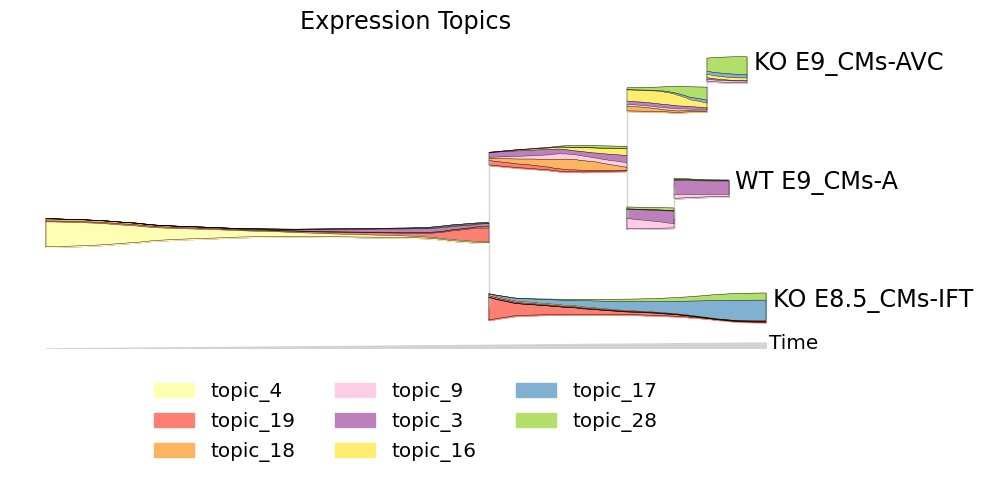

In [29]:
#Plot expression topics stream - all 8 topics of interest
plt.rcParams['font.size'] = 12
plot_kwargs = dict(hide_feature_threshold=0.03, linewidth=0.3, max_bar_height=0.8,
                    window_size=301, legend_cols=3, figsize = (10,5))

pal_warm = sns.color_palette('Set3')[1::2]
add_one = sns.color_palette('Set3')[4]
add_two = sns.color_palette('Set3')[6]
pal_man = pal_warm + [add_one] + [add_two]

mira.pl.plot_stream(data_sub_RNA,
                    data = ['topic_' + str(i) for i in [4,19,17,18,3,16,9,28]],
                    title = 'Expression Topics',
                    order = 'ascending',
                    log_pseudotime=False, 
                    palette = pal_man,
                    **plot_kwargs)

plt.savefig('plots/Mef2c_CM_IFT_streams_exp_topics_all.pdf')

plt.show()

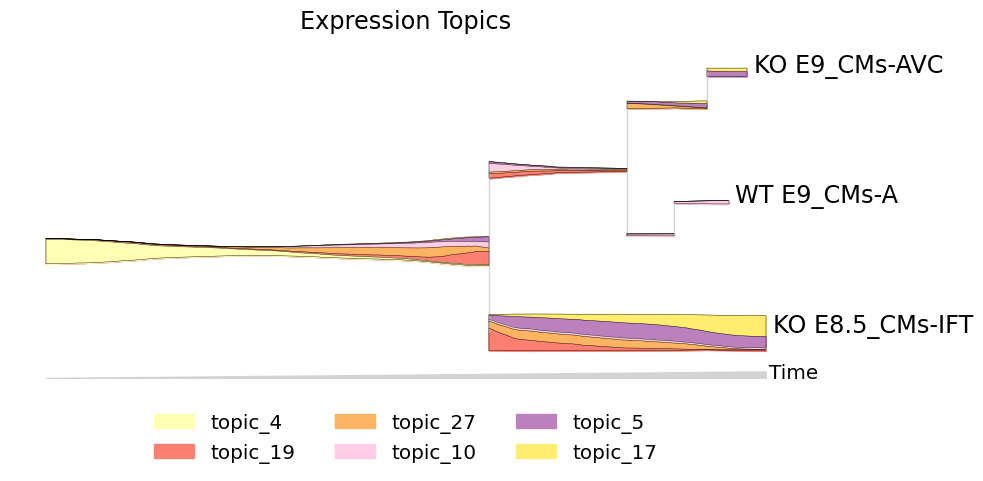

In [38]:
#Plot expression topics stream - focus on route to E8.5 KO IFT terminal state
plt.rcParams['font.size'] = 12
plot_kwargs = dict(hide_feature_threshold=0.03, linewidth=0.3, max_bar_height=0.8,
                    window_size=301, legend_cols=3, figsize = (10,5))

mira.pl.plot_stream(data_sub_RNA,
                    data = ['topic_' + str(i) for i in [4,19,10,27,5,17]],
                    title = 'Expression Topics',
                    order = 'ascending',
                    log_pseudotime=False, 
                    palette=sns.color_palette('Set3')[1::2], # warm tones
                    #palette = 'Set3',
                    **plot_kwargs)

plt.savefig('plots/Mef2c_CM_IFT_streams_exp_topics_subset1.pdf')

plt.show()

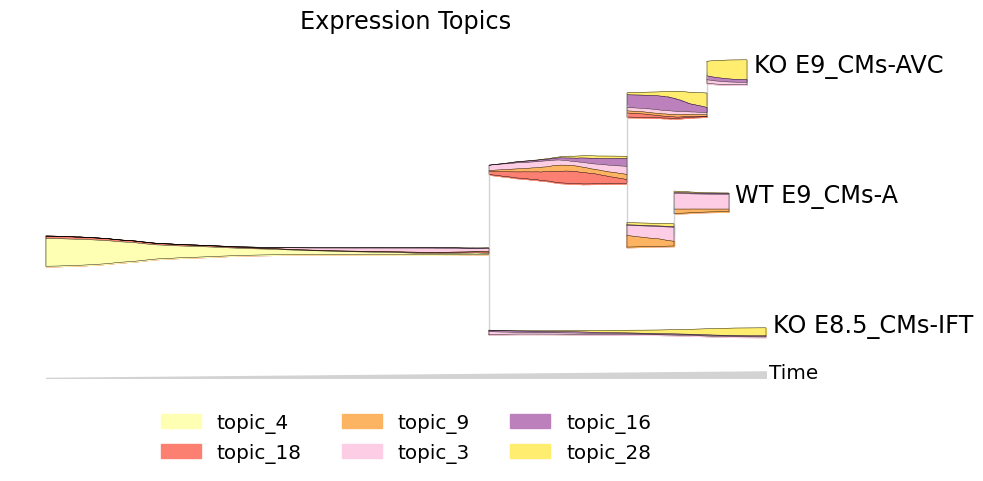

In [41]:
#Plot expression topics stream - focus on route to E9 WT/KO A/AVC terminal states
plt.rcParams['font.size'] = 12
plot_kwargs = dict(hide_feature_threshold=0.03, linewidth=0.3, max_bar_height=0.8,
                    window_size=301, legend_cols=3, figsize = (10,5))

mira.pl.plot_stream(data_sub_RNA,
                    data = ['topic_' + str(i) for i in [4,18,3,16,9,28]],
                    title = 'Expression Topics',
                    order = 'ascending',
                    log_pseudotime=False, 
                    palette=sns.color_palette('Set3')[1::2], # warm tones
                    #palette = 'Set3',
                    **plot_kwargs)

plt.savefig('plots/Mef2c_CM_IFT_streams_exp_topics_subset2.pdf')

plt.show()

In [ ]:
#Plot marker genes on the stream

#First, smooth the nomralized gene expression counts
data_sub_RNA.layers['smoothed'] = data_sub_RNA.obsp['connectivities'].dot(data_sub_RNA.layers['counts'])

#Stream plot
mira.pl.plot_stream(data_sub_RNA,
        data = ["Aldh1a2", "Tbx5", "Ttn", "Myl7", "Nr2f2", "Wnt2", "Gata4", "Tbx20", "Foxp1", "Mef2c"], # multiple genes
        layers = 'smoothed', # plot KNN-smoothed values
        style = "stream",
        split = True, # split features into separate plots
        color = "black",  # "color" overrides "palette" when there is just one feature
        clip = 3,
        scale_features=True,
        plots_per_row=2, # how many plots, per row
        log_pseudotime = False, window_size = 301,
        title  = 'Marker Genes')
plt.savefig('plots/Mef2c_CM_IFT_streams_marker_genes.pdf')
plt.show()

In [ ]:
#Get top genes from each topic
mef2c_exp_model.get_top_genes(16, top_n=50)

**Let's use Enrichr to examine functional enrichments for topics of interest
.post_topic sends the top genes to Enrichr**

**Note: A good rule of thumb for setting top_n genes is to take the top 5% of genes 
modeled by the expression topic model. 
In my case, I modeled ~4000 genes, so I post the top 200 genes.**

In [ ]:
#Start with Topic 16: Enriched in E9 KO CM-A
mef2c_exp_model.post_topic(16, top_n=200)

#Download and visualize the enrichment results
#Options or ontologies can be found here: https://maayanlab.cloud/Enrichr/#libraries
mef2c_exp_model.fetch_topic_enrichments(16, ontologies= ['WikiPathways_2019_Mouse'])
mef2c_exp_model.plot_enrichments(16, show_top=5)

#plt.savefig('plots/Topic26_E9_CM_V_WT_enrich.pdf')

### Accessibility Topic Analysis 

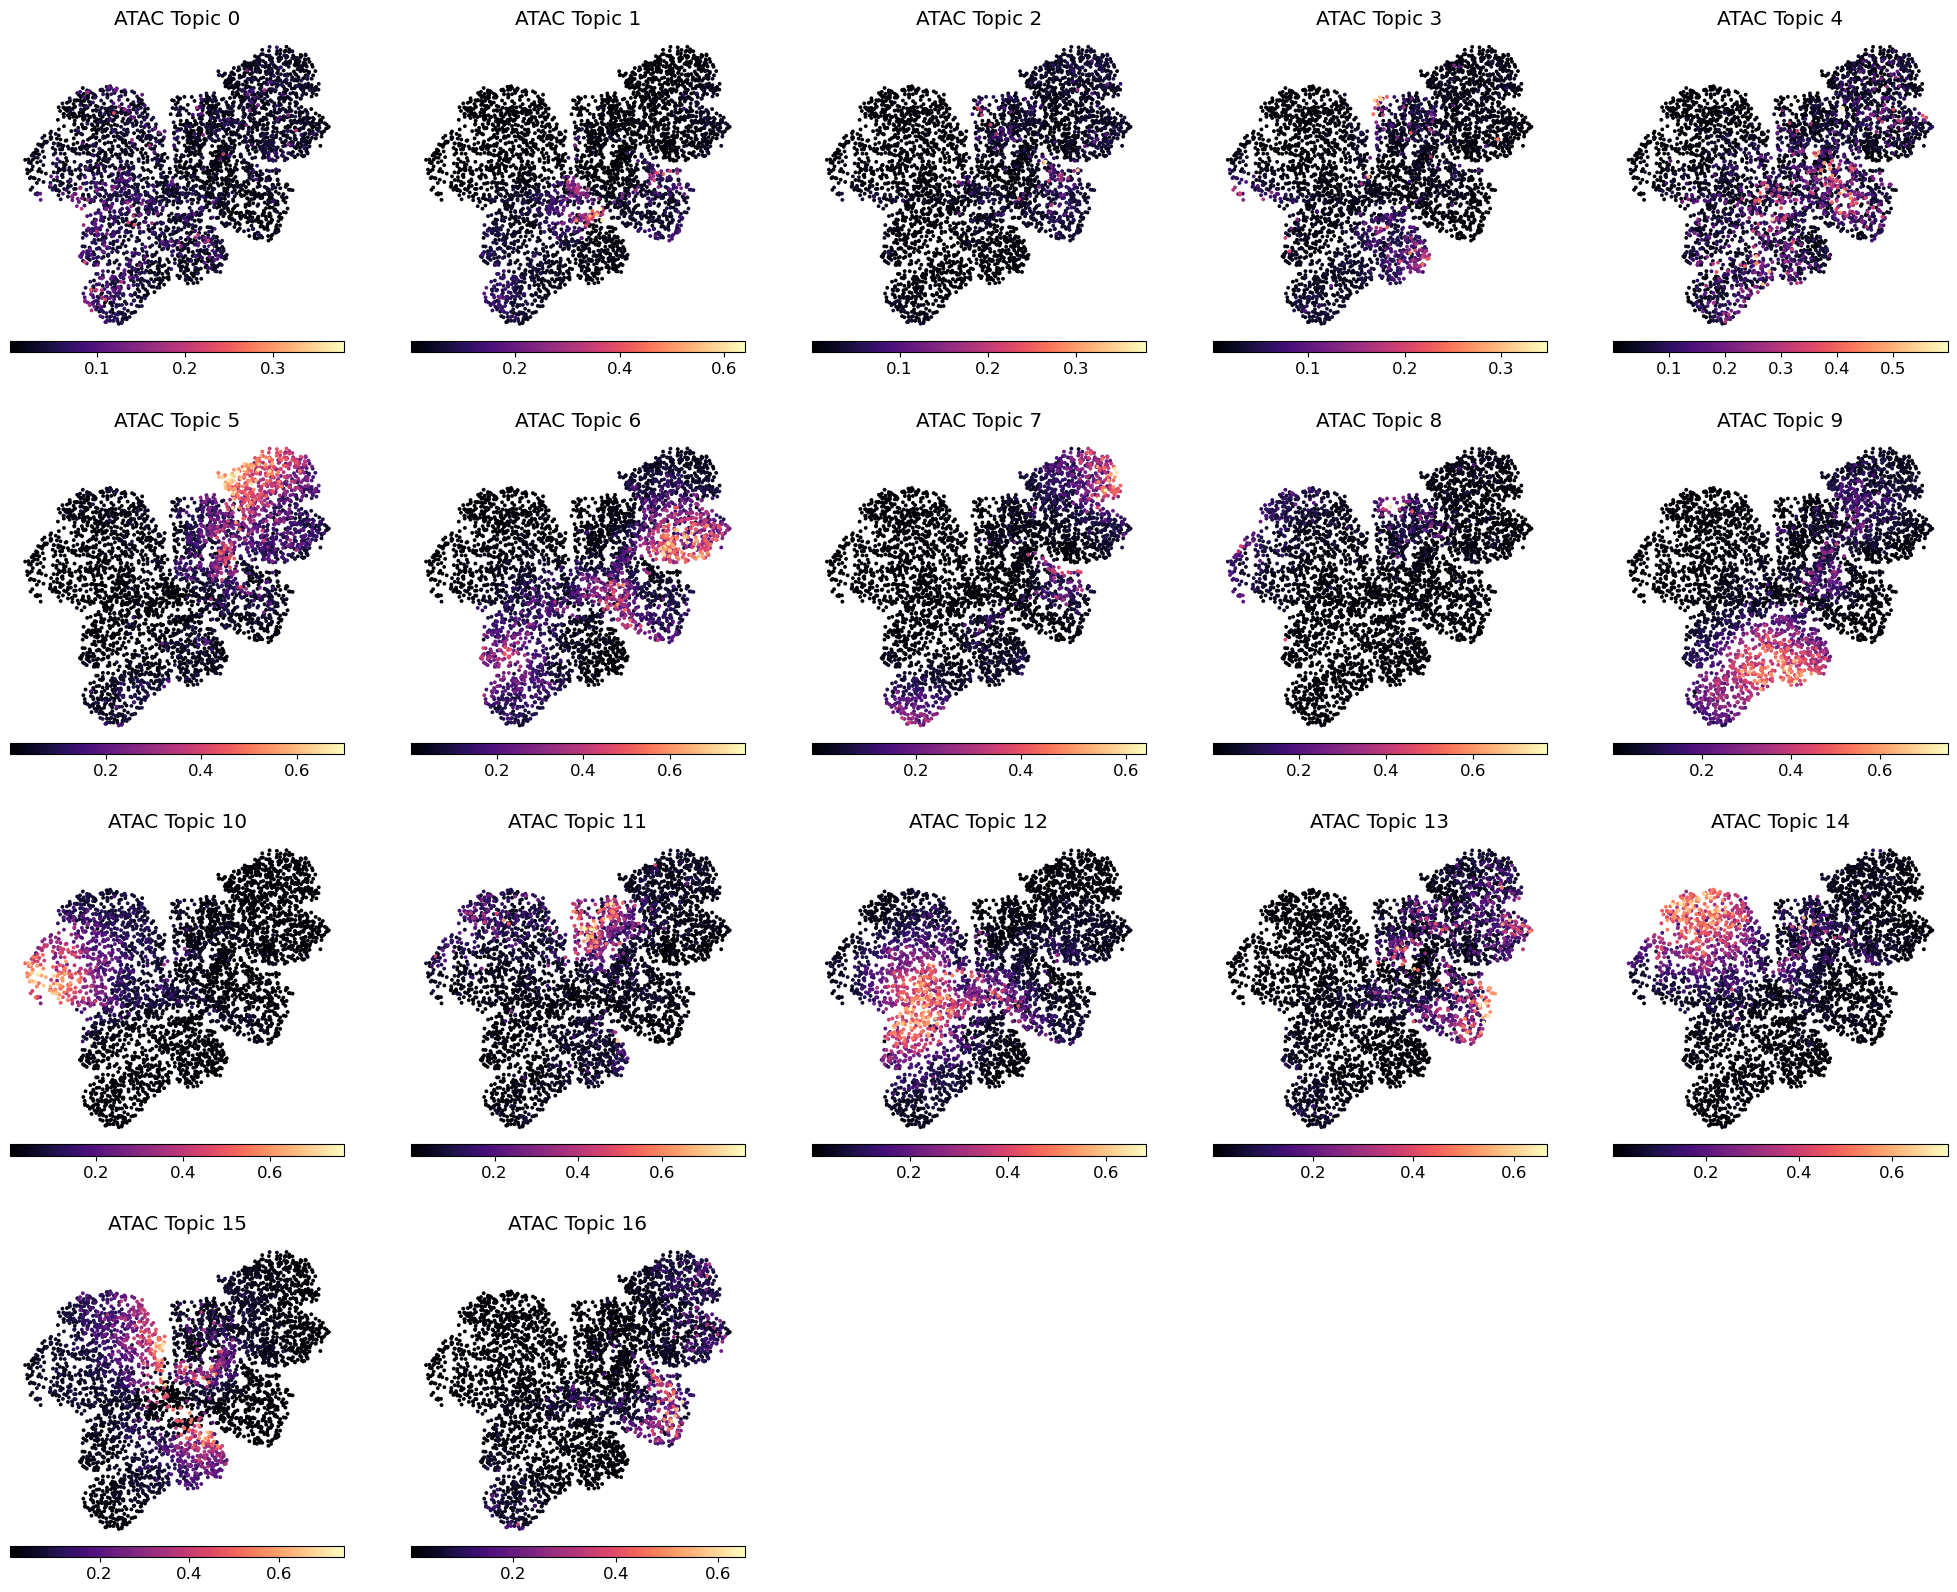

In [25]:
#Create a tiled UMAP montage to look at all accessibility topics 

#Plot titles
titles = [f"ATAC Topic {i}" for i in range(17)]

#And indexes for loop below
indexes = list(range(17))

def display_topics(ax, display, data):
    sc.pl.umap(data, ax = ax, show = False, title = '', colorbar_loc = 'bottom',
              color = f"ATAC_topic_{display}", color_map = 'magma')
    ax.set_title(titles[display])

fig, ax = plt.subplots(4,5, figsize=(25,20))

for i, ax_i in enumerate(ax.flatten()):
    ax_i.axis('off')
    if i < len(indexes):
        display_topics(ax_i, indexes[i], data_sub_RNA)
        ax_i.set_title(titles[indexes[i]])

plt.show()

By inspecting these plots, we can see the following topics of interest:  

- E8.5 pSHF: Topics 10, 14*
- E8.5 WT and KO IFT: Topics 12*
- E8.5 WT IFT: Topics 1
- E8.5 KO IFT: Topics 9*, 15
- E9 WT and KO A: Topic 11
- E9 WT A: Topics 13*, 16
- E9 KO A: Topics 6*
- E9 WT AVC: 16*
- E9 KO AVC: Topics 5*, 7

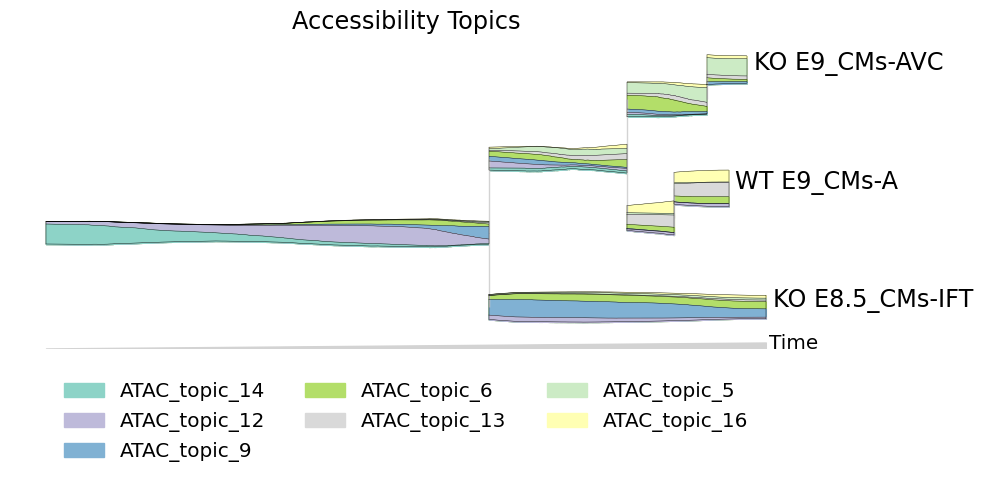

In [32]:
#Plot accessibility topics stream
plt.rcParams['font.size'] = 12
plot_kwargs = dict(hide_feature_threshold=0.03, linewidth=0.3, max_bar_height=0.8,
                    window_size=301, legend_cols=3, figsize = (10,5))

pal_cool = sns.color_palette('Set3')[::2]
add_one = sns.color_palette('Set3')[1]
pal_man = pal_cool + [add_one] 

mira.pl.plot_stream(data_sub_RNA,
                    data = ['ATAC_topic_' + str(i) for i in [14,12,9,13,6,16,5]],
                    title = 'Accessibility Topics',
                    order = 'ascending',
                    log_pseudotime=False, 
                    palette = pal_man,
                    **plot_kwargs)

plt.savefig('plots/Mef2c_CM_IFT_streams_atac_topics_all.pdf')

plt.show()

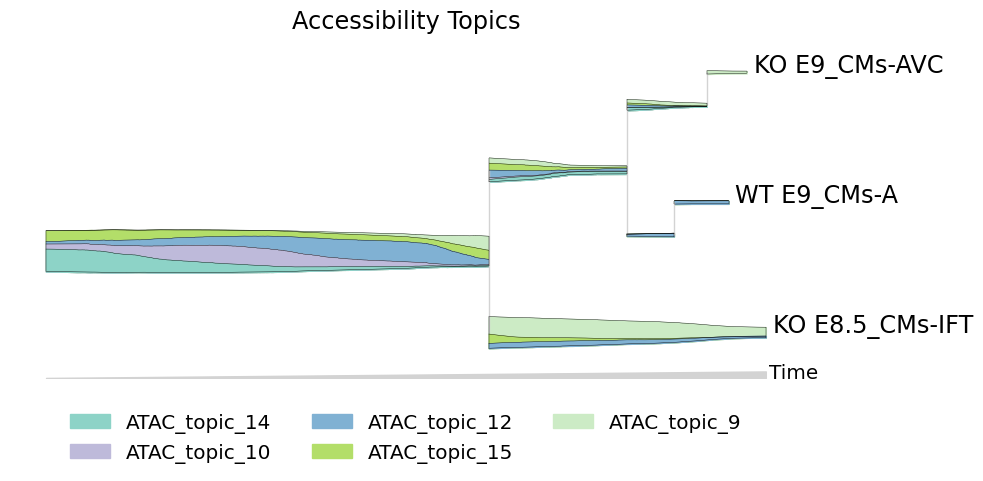

In [35]:
#Plot accessibility topics stream - focus on route to E8.5 KO IFT terminal state
plt.rcParams['font.size'] = 12
plot_kwargs = dict(hide_feature_threshold=0.03, linewidth=0.3, max_bar_height=0.8,
                    window_size=301, legend_cols=3, figsize = (10,5)) 

pal_cool = sns.color_palette('Set3')[::2]
pal_man = [pal_cool[i] for i in [0, 1, 2, 3, 5]]

mira.pl.plot_stream(data_sub_RNA,
                    data = ['ATAC_topic_' + str(i) for i in [10,14,12,9,15]],
                    title = 'Accessibility Topics',
                    order = 'ascending',
                    log_pseudotime=False, 
                    palette = pal_man, 
                    **plot_kwargs)

plt.savefig('plots/Mef2c_CM_IFT_streams_atac_topics_subset1.pdf')

plt.show()

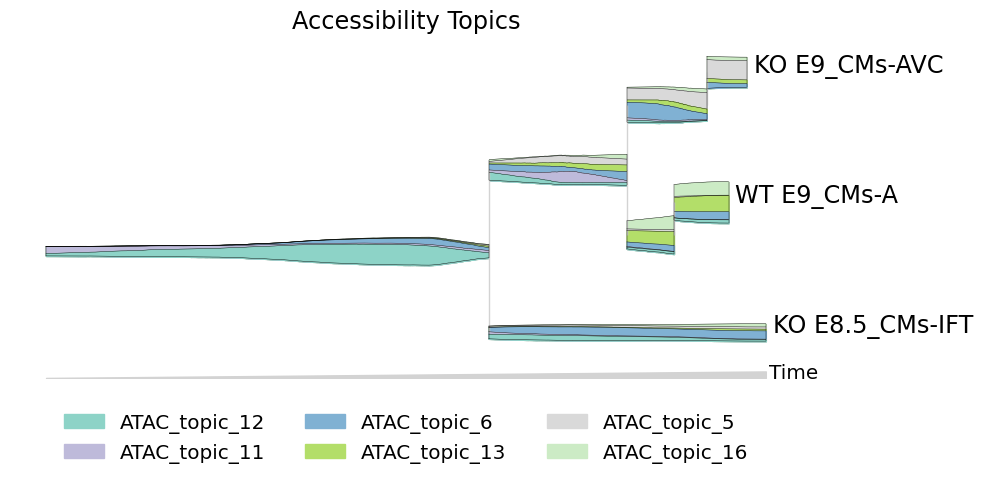

In [37]:
#Plot accessibility topics stream - focus on route to E9 WT/KO A/AVC terminal states
plt.rcParams['font.size'] = 12
plot_kwargs = dict(hide_feature_threshold=0.03, linewidth=0.3, max_bar_height=0.8,
                    window_size=301, legend_cols=3, figsize = (10,5)) 

mira.pl.plot_stream(data_sub_RNA,
                    data = ['ATAC_topic_' + str(i) for i in [12,11,13,6,16,5]],
                    title = 'Accessibility Topics',
                    order = 'ascending',
                    log_pseudotime=False, 
                    palette = sns.color_palette('Set3')[::2], #cool tones
                    **plot_kwargs)

plt.savefig('plots/Mef2c_CM_IFT_streams_atac_topics_subset2.pdf')

plt.show()

In [ ]:
#Save subset AnnData objects
data_sub_RNA.write_h5ad(filename="Lineage_AnnData/Mef2c_CM-IFT_RNA_AnnData.h5ad")
data_sub_Peaks.write_h5ad(filename="Lineage_AnnData/Mef2c_CM-IFT_Peaks_AnnData.h5ad")